In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl 
%matplotlib inline
mpl.rcParams['patch.force_edgecolor'] = True
sns.set()

# Wrangle Data

In [2]:
##Import & process data

# Import
engage = pd.read_csv('C:/Users/melin/Documents/Springboard Data Science Career Track/Example Take-Home Challenge - Relax Inc/1481069814_relax_challenge/relax_challenge/takehome_user_engagement.csv')

# Convert dates to datetime objs to remove hour/min/sec info, since "adopted" user is based on days
engage['time_stamp'] = list(map(lambda x: datetime.strptime(x.split()[0],'%Y-%m-%d'), engage['time_stamp']))

print("Rows, columns: ", engage.shape)
print("Earliest time_stamp: ", engage['time_stamp'].min())
print("Latest time_stamp: ", engage['time_stamp'].max(), '\n')
engage.head()

Rows, columns:  (207917, 3)
Earliest time_stamp:  2012-05-31 00:00:00
Latest time_stamp:  2014-06-06 00:00:00 



,time_stamp,user_id,visited
0,2014-04-22,1,1
1,2013-11-15,2,1
2,2013-11-29,2,1
3,2013-12-09,2,1
4,2013-12-25,2,1


In [3]:
# Import
users = pd.read_csv('C:/Users/melin/Documents/Springboard Data Science Career Track/Example Take-Home Challenge - Relax Inc/1481069814_relax_challenge/relax_challenge/takehome_users.csv',  encoding='latin-1')

# Convert dates to datetime objs
users['creation_time'] = list(map(lambda x: datetime.strptime(x.split()[0],'%Y-%m-%d'), users['creation_time'])) 
print("Rows, columns: ", users.shape)
print("Earliest creation_time: ", users['creation_time'].min())
print("Latest creation_time: ", users['creation_time'].max())
users.head()

Rows, columns:  (12000, 10)
Earliest creation_time:  2012-05-31 00:00:00
Latest creation_time:  2014-05-30 00:00:00


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
##Check number of users
print("Number of unique user id's: ", len(users['object_id'].unique()))
print("Number of unique user names: ", len(users['name'].unique()))
print("Number of unique emails: ", len(users['email'].unique()))

Number of unique user id's:  12000
Number of unique user names:  11355
Number of unique emails:  11980


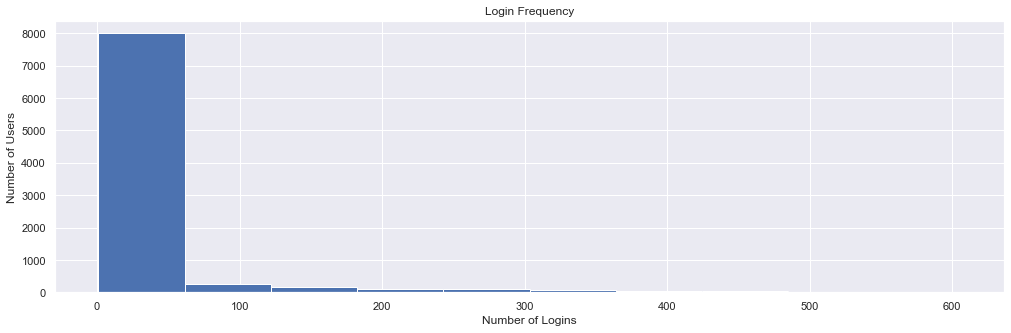

In [5]:
##Check distribution of logins
plt.figure(figsize=(17,5));
plt.hist(engage.groupby('user_id').size());
plt.title('Login Frequency');
plt.xlabel('Number of Logins');
plt.ylabel('Number of Users');

According to the figure above, there are 12000 unique users. However, the number of unique names (11355) and emails (11980) do not match. This indicates that there may be individuals duplicated in the database. If it is assumed that different individuals have identical names and go by email as the reference point for identifying duplicated individuals, there would only be 20 duplicated individuals in our database. That's pretty small, so for simplicity we stick with 'object_id' (user id) as the reference points for looking up each individual's logins. The data spans 2012-2014. Majority of users have less than 50 logins. There is also a small but significant cluster of users who are clearly active - adopted users with more than 100 logins.

# Identify & Examine Adopted Users

In [6]:
##Grab each user's logins
user_timestamps = [] # list of arrays, where each array is a user's logins
for idx, row in users.iterrows():
    user_id = row['object_id']
    timestamps = engage[engage['user_id']==user_id]['time_stamp']
    t = [i for i in timestamps]
    user_timestamps.append(t)

#### Create function that determines whether the user has logged in on 3 separate days in at least one 7-day period¶
This is predicated on calculating the time elapsed between each login. In the case that multiple logins occur on the same day, which might confound this analysis, these "duplicate" logins are removed.

In [7]:
def adopted(x): # x = list of user's logins ('Timestamp' data type)
    if len(x) < 3:
        return 0
    else:
        x.sort()  
        y = [x[i+1] - x[i] for i in range(len(x)-2)] # amount of days between logins
        y = [i for i in y if i > timedelta(days=0)] # delete extra logins occurring on same day
        z = [1 for i in range(len(y)-2) if y[i] + y[i+1] + y[i+2] <= timedelta(days=7)]
        # condition to check if there`s a 1 in x, return 1 if true
        if 1 in z:
            return 1
        else:
            return 0

#### Identify adopted users
Adopted user is the user who has logged into the product on three separate days in at least one seven-day period.

In [8]:
adopt_total = []
for user in user_timestamps:
        adopt_total.append(adopted(user))

users['adopted'] = adopt_total

In [9]:
print("Number of adopted users: ", sum(adopt_total))
print("Fraction adopted users: ", sum(adopt_total)/len(adopt_total))

Number of adopted users:  1322
Fraction adopted users:  0.11016666666666666


About 11% of customers are adopted users. That means many users who aren't adopted will definitely be valuable for the company to target.

# Examine Variables

In [10]:
##Make dataframe of 'features' by dropping irrelevant info such as name, email, etc.
features = pd.DataFrame.copy(users)
features = features.drop(['name', 'email', 'object_id', 'creation_time', 
                                'last_session_creation_time', 'invited_by_user_id'], axis=1)
features.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted
0,GUEST_INVITE,1,0,11,0
1,ORG_INVITE,0,0,1,0
2,ORG_INVITE,0,0,94,0
3,GUEST_INVITE,0,0,1,0
4,GUEST_INVITE,0,0,193,0


In [11]:
##Convert 'creation_source' variable to numeric
print('Unique creation sources: ', features['creation_source'].unique())

Unique creation sources:  ['GUEST_INVITE' 'ORG_INVITE' 'SIGNUP' 'PERSONAL_PROJECTS'
 'SIGNUP_GOOGLE_AUTH']


<b>Convert:</b>

- 'GUEST_INVITE' = 0
- 'ORG_INVITE' = 1
- 'SIGNUP' = 2
- 'PERSONAL_PROJECTS' = 3
- 'SIGNUP_GOOGLE_AUTH' = 4

In [12]:
creation = {'GUEST_INVITE':0,
            'ORG_INVITE':1,
            'SIGNUP':2,
            'PERSONAL_PROJECTS':3,
            'SIGNUP_GOOGLE_AUTH':4}
features['creation_source'] = features['creation_source'].map(lambda i: creation[i])

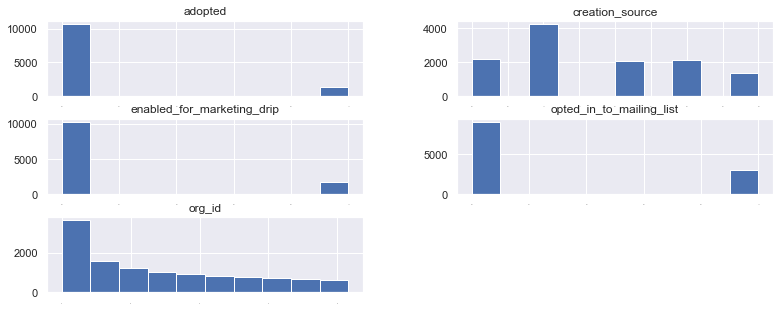

In [13]:
##Examine distribution of variables
features.hist(sharex=False, sharey=False, xlabelsize=1, figsize=(13,5));

None of the variables have a continuous normal distribution.

In [14]:
##Scale variables
#MinMaxScaler will be used as it's more appropriate for data that aren't normally distributed.
from sklearn.preprocessing import MinMaxScaler

x = features.drop('adopted', axis=1)
y = users['adopted']

scaler = MinMaxScaler()
scaler.fit(x)
x = scaler.fit_transform(x)

In [15]:
# Temporarily put into a dataframe to easily visualize how the variables have been converted
pd.DataFrame(x).head()

,0,1,2,3
0,0.00,1.0,0.0,0.026442
1,0.25,0.0,0.0,0.002404
2,0.25,0.0,0.0,0.225962
3,0.00,0.0,0.0,0.002404
4,0.00,0.0,0.0,0.463942


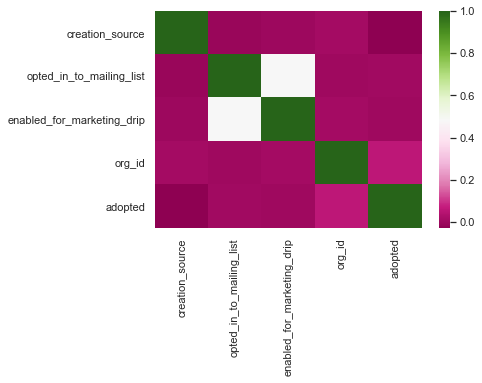

In [16]:
##Create correlation matrix to see whether or not there is correlation among the variables.
sns.heatmap(features.corr(), cmap="PiYG");

'Enabled_for_marketing_drop' and 'opted_in_to_mailing_list' appear to be moderately correlated. These variables should be noted in case they need to be dropped to improve the model, since intercorrelated variables may hinder model performance.

# Test Models

Several models will be tested before narrowing down to one. Then, the parameters will be tuned.

In [17]:
##Split features into train/test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=99)

In [18]:
##Testing multiple ML approaches

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import RandomForestClassifier

num_folds=10
scoring='roc_auc'

models=[]
models.append(('LR', LogisticRegression()))
models.append(('KN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('B', MultinomialNB()))

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.567146 (0.034180)
KN: 0.543460 (0.037450)
RF: 0.531146 (0.039779)
B: 0.559270 (0.037503)


The logistic regression model will be picked as it has the best ROC-AUC value.

In [19]:
##Tune the model to see if further improvements can be obtained

from sklearn.metrics import confusion_matrix

# Re-instantiate model
model = LogisticRegression() # instantiate logreg w/ l1 regularization
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Confusion matrix
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))

Confusion matrix: 
[[3209    0]
 [ 391    0]]


The performance of the model is excellent for not having false positives (non-adopted users falsely identified as adopted). This means that no non-adopted user slips through the cracks if Relax Inc. decides to target non-adopted users with specific ads, etc. for retaining them. However, there are 391 false negatives in which adopted users were misclassified as non-adopters. This might not be a significant issue though, depending on Relax's strategy of targeting non-adopted users. Maybe they will continue to be adopters even if they are targeted with non-adopter ads for instance. This would mean FN's aren't costly. Nonetheless, the model would be checked if it can better performance with Lasso regularization.

In [20]:
model = LogisticRegression(penalty='l1', solver='liblinear') # instantiate logreg w/ l1 regularization
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Confusion matrix
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))

Confusion matrix: 
[[3209    0]
 [ 391    0]]


The results are still the same in this case. Perhaps just for these train and test sets, but the difference seems likely to be insignificant.

# Examine Importance of Variables

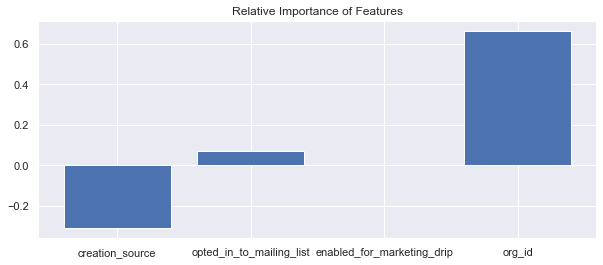

In [21]:
##Plot relative importance of variables
df_features = features.columns[:-1].tolist()
coefs = model.coef_[0]

plt.figure(figsize=(10,4));
plt.bar(df_features, coefs);
plt.title('Relative Importance of Features');

<b>'creation_source'</b> and <b>'org_id'</b> seem to be the most important variables. However, it's difficult to make specific recommendations since the above plot only shows that they're heavily weighted. Thus, they will be examined more closely.

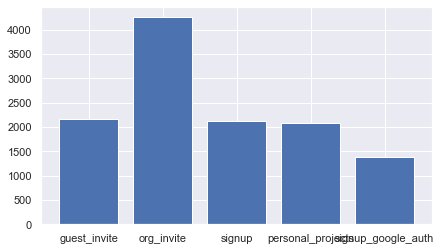

In [23]:
names = ['guest_invite', 'org_invite', 'signup', 'personal_projects', 'signup_google_auth']
count = users.groupby('creation_source').size().tolist()

plt.figure(figsize=(7,4));
plt.bar(names, count);

The most common creation source seems to be 'org_invite'. This makes sense, since 'org_id' is the other feature with a relatively large weight. The next plot will examine 'org_id' next.

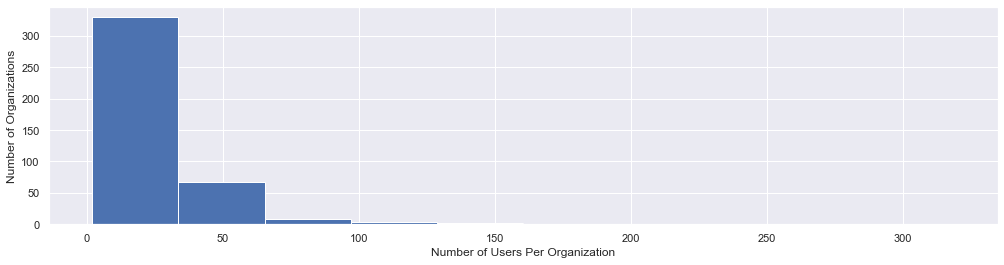

In [24]:
count = users.groupby('org_id').size()
plt.figure(figsize=(17,4))
plt.hist(count);
plt.xlabel('Number of Users Per Organization');
plt.ylabel('Number of Organizations');

Majority of the organizations (group of users by 'org_id') seem to have less than 70 members. However, there are a few large organizations with many more members. The next plot will examine them more closely.

Total organizations with more than 70 users:  18


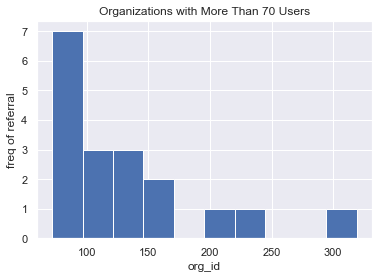

In [25]:
test = pd.DataFrame({'count':count.tolist(), 'org_id':count.index})
test = test[test['count'] > 70]['count']
plt.hist(test);
plt.xlabel('org_id');
plt.ylabel('freq of referral');
plt.title('Organizations with More Than 70 Users');
print('Total organizations with more than 70 users: ', len(test))

There are 18 organizations more than 70 users. These organizations might be worth targeting to get more even users.

# Conclusion

The most important variables were 'org_id' and 'creation_source'. It seems that many of Relax Inc's users are influenced to adopt by virtue of being part of an organization or how they were invited.

Upon closer examination of these variables, whether the user was prompted to adopt due to being part of an organization is probably the most important factor in determining whether or not they will adopt. There are 18 organizations with more than 70 users.

<b>Recommendation:</b> To increase the number of adopters, it may be more fruitful to target organizations rather than individual customers. In other words, Relax Inc. should focus on encouraging organizations to enroll large numbers of their members. Individual-level factors such as how users signed up (not including via an organization) and whether or not they were on a mailing list are not nearly as significant as whether or not they were part of an organization.